# 1. Heston Model Setup

The Heston model belongs to the class of stochastic volatility models. In particular, the variance process, $v=(v_t)_{t\geq0}$ is modeled using a Feller process. 

In this project, I consider an asset price $S = (S_t)_{t\geq0}$ and it's instantenous variance $v=(v_t)_{t\geq0}$ follow the Heston model, i.e., they satisfy the coupled SDE

\begin{align}
    dS_t &= S_t \sqrt{v_t} dW_t^S \label{dS_t}\\
    dv_t &= \kappa(\theta-v_t)dt + \eta \sqrt{v_t} dW_t^v \label{dv_t}
\end{align}
where $(W_t^S, W_t^v)$ are correlated risk-neutral Brownian motions with correlation $\rho$.

I use the following base model parameters throughout this project:

$r=0 \hskip 1em S_0=1 \hskip 1em \sqrt{v_0} = 20\% \hskip 1em \kappa=3 \hskip 1em \sqrt{\theta} = 40\% \hskip 1em \eta = 1.5 \hskip 1em \rho=-0.5$

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
import mibian
import scipy.stats as si

In [2]:
# set plotting style
import seaborn as sns
sns.set_theme()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 18,
          'figure.figsize': (10, 6),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
pylab.rcParams.update(params)
%matplotlib inline

In [3]:
# base parameters
S0 = 1
v0 = 0.2**2
kappa = 3
theta = 0.4**2
eta = 1.5
rho = -0.5

In the following sections, I intend to estimate the implied volatility smils of a put/call options using Monte Carlo simulation via two approaches.

## 1.1 Euler Discretization and Milstein Discretization

The first approach I tried is to Euler discretize the log asset price process, $x_t = \log S_t$ and Milstein discretization of $v_t$.

The discretization is given by:

\begin{align}\label{x_t Euler}
    x_{t+\Delta t} &= x_t -\frac{1}{2} v_t \Delta t+\sqrt{v_t\cdot \Delta t}\ \varepsilon_t^S
\end{align}

\begin{equation}\label{Milstein v_t}
    v_{t+\Delta t} = v_t + \kappa(\theta-(v_t)_+)\Delta t + \eta\sqrt{(v_t)_+\Delta t}\cdot \varepsilon_t^v + \frac{\eta^2}{4}((\varepsilon_t^v)^2-1)\Delta t
\end{equation}

where 
$
\left( \begin{array}{cc} \varepsilon_t^S \\ \varepsilon_t^v
\end{array}\right) \overset{\mathbb{Q}}{\sim} \mathcal{N}
\left( \left( \begin{array}{cc} 0 \\ 0\end{array}\right),\left( \begin{array}{cc} 1 & \rho \\ \rho & 1
\end{array}\right) \right)
$

### 1.1.1 Generate process of $v_t$ and $S_t$**

Throughout this project, I use 5,000 simulations, the step size is equal to $\Delta t = 1/1000$

In [4]:
# simulation parameters
Nsims = 5_000

In [5]:
def HeMC1 (S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    # time grid
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    # generate standard brownian motion for stock price process and variance process
    MU = np.array([0,0])
    COV = np.matrix([[1, rho],[rho,1]])
    e = np.random.multivariate_normal(MU,COV,size=(Nsims,t.shape[0]))
    e_S = e[:,:,0]
    e_v = e[:,:,1]
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    Xt = np.zeros((Nsims, NdT))
    Xt[:,0] = np.log(S0)
    
    correction = 0.25*eta**2*(e_v**2-1)*dt

    for i in range(len(t)-1):
        
        # Milstein discretization of vt
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*e_v[:,i] + correction[:,i]
        
        # Euler discretization of Xt
        Xt[:,i+1] = Xt[:,i] - 0.5*np.maximum(vt[:,i],0)*dt + np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*e_S[:,i]
        
    St = np.exp(Xt)
    
    return St, vt, t

When option maturity T = 1/4, $S_t$ and $v_t$ processes

In [6]:
St1, vt1, t1 = HeMC1(S0,v0,rho,kappa,theta,eta,T=1/4,Nsims=5_000)

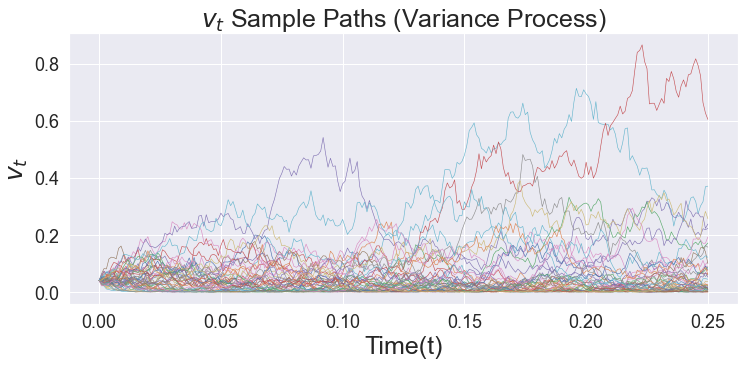

In [7]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t1,vt1[i,:],linewidth=0.6)
plt.title(r'$v_t$ Sample Paths (Variance Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$v_t$')
plt.show()

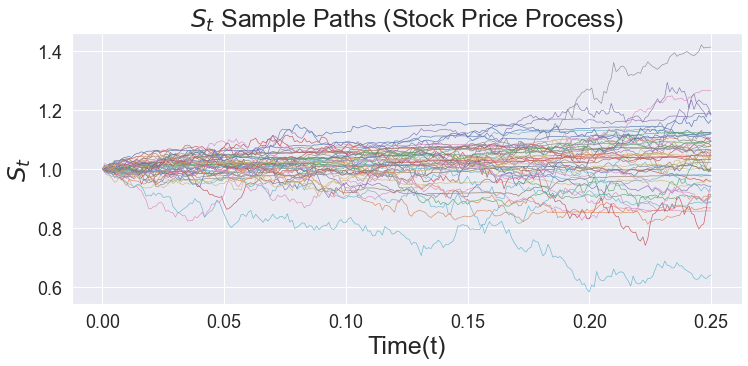

In [8]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t1,St1[i,:],linewidth=0.6)
plt.title(r'$S_t$ Sample Paths (Stock Price Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$S_t$')
plt.show()

When option maturity T=1/2, $S_t$ and $v_t$ processes

In [9]:
St2, vt2, t2 = HeMC1(S0,v0,rho,kappa,theta,eta,T=1/2,Nsims=5_000)

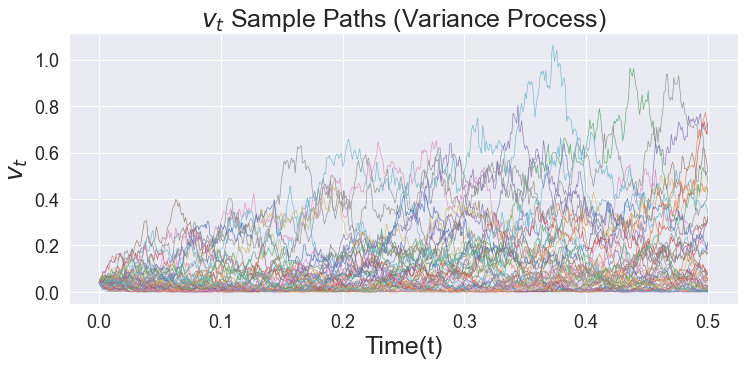

In [10]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t2,vt2[i,:],linewidth=0.6)
plt.title(r'$v_t$ Sample Paths (Variance Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$v_t$')
plt.show()

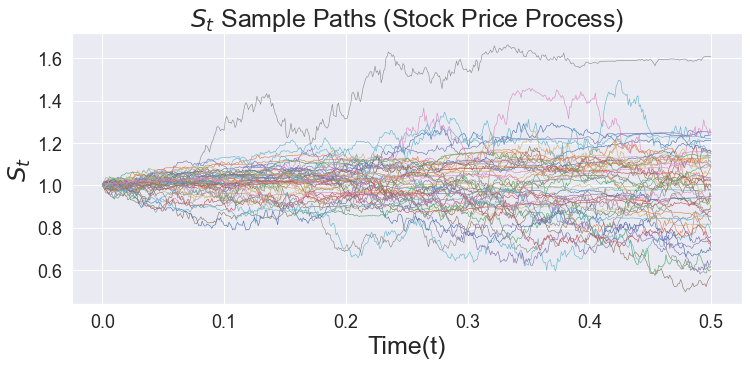

In [11]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t2,St2[i,:],linewidth=0.6)
plt.title(r'$S_t$ Sample Paths (Stock Price Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$S_t$')
plt.show()

When option maturity T=1, $S_t$ and $v_t$ processes

In [12]:
St3, vt3, t3 = HeMC1(S0,v0,rho,kappa,theta,eta,T=1,Nsims=5_000)

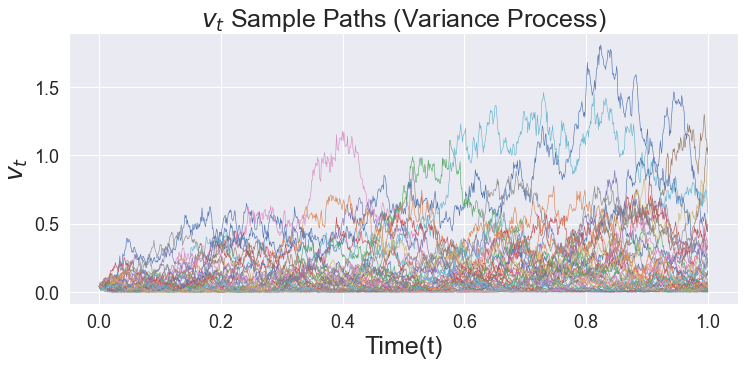

In [13]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t3,vt3[i,:],linewidth=0.6)
plt.title(r'$v_t$ Sample Paths (Variance Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$v_t$')
plt.show()

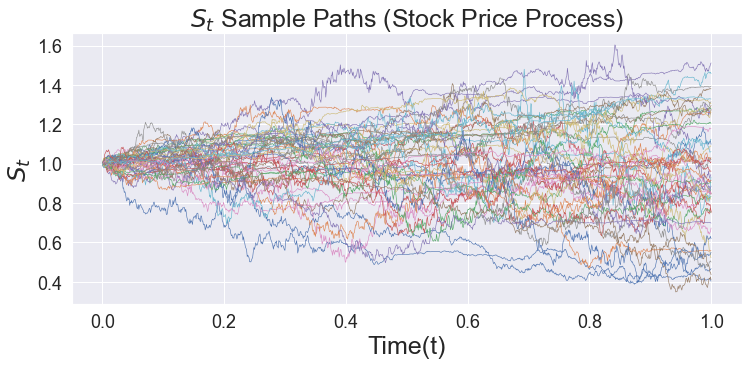

In [14]:
plt.figure(figsize=(12,5))
for i in range(0,50):
    plt.plot(t3,St3[i,:],linewidth=0.6)
plt.title(r'$S_t$ Sample Paths (Stock Price Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$S_t$')
plt.show()

### 1.1.2 Market price of the option

The implied volatility is defined by finding the inverse of the Black-Scholes formula, that is to calculate the volatility of an option given the option price, stock price, strike price etc.

For this project, I consider the strike price $K = 0.8,0.85,...,1.2$ with maturities $T = 1/4,1/2,1$

The market option price is determined by Monte Carlo simulation. 

In [15]:
def sim_option(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    St, vt, t = HeMC1(S0,v0,rho,kappa,theta,eta,T,Nsims)
    
    option_mkt_price = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            option_mkt_price[i] = np.mean(np.maximum((strikes[i]-St[:,-1]),0))
    
        elif strikes[i] >= S0:
            # call option
            option_mkt_price[i] = np.mean(np.maximum(St[:,-1]-strikes[i],0))
    
    return option_mkt_price

T = 1/4 Option Market Prices

In [16]:
option_mkt_price1 = sim_option(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)
option_mkt_price1

array([0.00763953, 0.01224593, 0.01944568, 0.03044682, 0.04750471,
       0.0244827 , 0.01177337, 0.00575096, 0.00298026])

T = 1/2 Option Market Prices

In [17]:
option_mkt_price2 = sim_option(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)
option_mkt_price2

array([0.02075603, 0.02903159, 0.03996459, 0.05469604, 0.07651032,
       0.05221348, 0.03447046, 0.02243865, 0.01445657])

T = 1 Option Market Prices

In [18]:
option_mkt_price3 = sim_option(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)
option_mkt_price3

array([0.05036556, 0.06365226, 0.07967609, 0.09891172, 0.12261203,
       0.09849301, 0.0781125 , 0.06124933, 0.04767626])

### 1.1.3 Implied Volatility with Different Maturities

* Method 1: Use the Mibian package to calculate the implied volatility directly

Example regarding how to use this package:
https://github.com/mayank-quant/options_and_python/blob/master/options_pricing_using_python.ipynb

Original package construction:
https://github.com/yassinemaaroufi/MibianLib/blob/master/mibian/__init__.py

**Calculate the implied volatility with different maturities**

In [19]:
# without confidence intervals
def IV_simulation1(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    St, vt, t = HeMC1(S0,v0,rho,kappa,theta,eta,T,Nsims)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            option_mkt_price[i] = np.mean(np.maximum((strikes[i]-St[:,-1]),0))
            
            # calculate put price implied volatility
            p = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price[i])
            implied_volatility[i] = p.impliedVolatility
    
        elif strikes[i] >= S0:
            # call option
            option_mkt_price[i] = np.mean(np.maximum(St[:,-1]-strikes[i],0))
            
            # calculate call price implied volatility
            c = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price[i])    
            implied_volatility[i] = c.impliedVolatility
    
    return option_mkt_price, strikes, implied_volatility

In [20]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_simulation1(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_simulation1(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)
option_mkt_price_year, strikes, implied_volatility_year = IV_simulation1(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

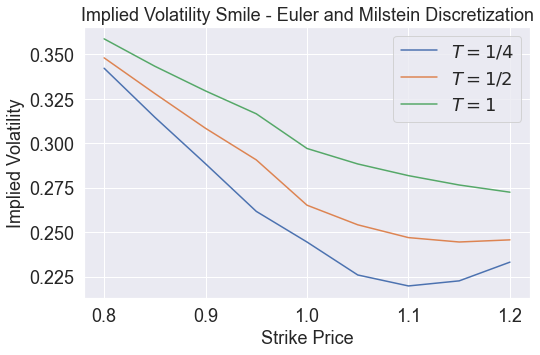

In [21]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter/100,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear/100,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year/100,label = r"$T=1$")
plt.title('Implied Volatility Smile - Euler and Milstein Discretization',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

* Method 2: Use Newton method and give the initial derivative estimate

https://aaronschlegel.me/implied-volatility-functions-python.html

https://www.codearmo.com/blog/implied-volatility-european-call-python

In [22]:
N_prime = norm.pdf
N = norm.cdf

def vega(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)
    
    vega = S  * np.sqrt(T) * N_prime(d1)
    
    return vega

In [23]:
def black_scholes_call(S, K, T, r, sigma):

    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call

In [24]:
def black_scholes_put(S, K, T, r, sigma):

    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put =  N(-d2)* K * np.exp(-r * T) - S * N(-d1) 
    return put

In [25]:
def implied_volatility_call(C, S, K, T, r, tol=0.0001,max_iterations=100):
    
    sigma = 0.3
    
    for i in range(max_iterations):
        
        diff = black_scholes_call(S, K, T, r, sigma) - C
        
        if abs(diff) < tol:
            break
        
        sigma = sigma - diff / vega(S, K, T, r, sigma)
        
    return sigma

In [26]:
def implied_volatility_put(P, S, K, T, r, tol=0.0001,max_iterations=100):
    
    sigma = 0.3
    
    for i in range(max_iterations):
        
        diff = black_scholes_put(S, K, T, r, sigma) - P
        
        if abs(diff) < tol:
            break
        
        sigma = sigma - diff / vega(S, K, T, r, sigma)
        
    return sigma

In [27]:
# thire method is to use newton method without using the scipy pacakge and without confidence interval
def IV_simulation2(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    St, vt, t = HeMC1(S0,v0,rho,kappa,theta,eta,T,Nsims)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            option_mkt_price[i] = np.mean(np.maximum((strikes[i]-St[:,-1]),0))
            
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
    
        elif strikes[i] >= S0:
            # call option
            option_mkt_price[i] = np.mean(np.maximum(St[:,-1]-strikes[i],0))
    
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
    
    return option_mkt_price, strikes, implied_volatility

In [28]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_simulation2(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_simulation2(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)
option_mkt_price_year, strikes, implied_volatility_year = IV_simulation2(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

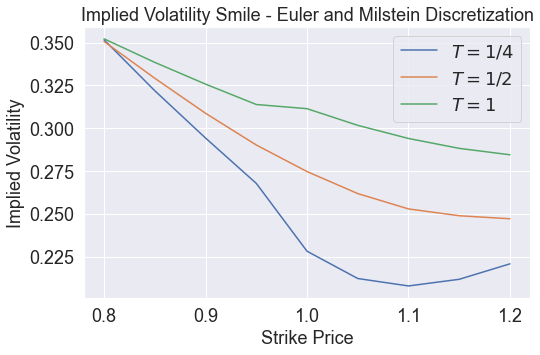

In [29]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile - Euler and Milstein Discretization',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

Note that for $K < S_0$, I use put option price and for $K \geq S_0$, I use call option price.

**Implied Volatility Confidence Intervals**

In addition to the implied volatility smile, I also estimate the 95% confidence interval associate with the simulation method.

Method 1: mibian package

In [30]:
# with confidence intervals
def IV_simulation1_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    St, vt, t = HeMC1(S0,v0,rho,kappa,theta,eta,T,Nsims)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            payoff = np.maximum((strikes[i]-St[:,-1]),0)
            
            option_mkt_price[i] = np.mean(payoff)
            option_mkt_price_lower[i] = np.mean(payoff) - 1.96*np.std(payoff)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(payoff) + 1.96*np.std(payoff)/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            p1 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price[i])
            implied_volatility[i] = p1.impliedVolatility
            p2 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price_lower[i])
            implied_volatility_lower[i] = p2.impliedVolatility
            p3 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price_upper[i])
            implied_volatility_upper[i] = p3.impliedVolatility

    
        elif strikes[i] >= S0:
            # call option
            payoff = np.maximum((St[:,-1]-strikes[i]),0)
            option_mkt_price[i] = np.mean(payoff)
            option_mkt_price_lower[i] = np.mean(payoff) - 1.96*np.std(payoff)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(payoff) + 1.96*np.std(payoff)/np.sqrt(Nsims)
            
            # calculate call price implied volatility
            c1 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price[i])
            implied_volatility[i] = c1.impliedVolatility
            c2 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price_lower[i])
            implied_volatility_lower[i] = c2.impliedVolatility
            c3 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price_upper[i])
            implied_volatility_upper[i] = c3.impliedVolatility

                
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [31]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation1_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

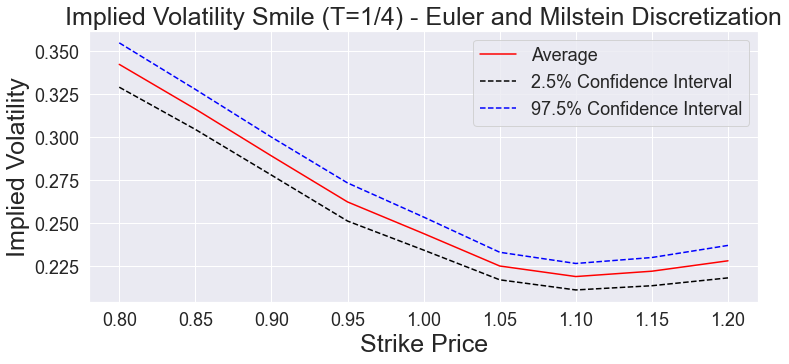

In [32]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) - Euler and Milstein Discretization')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [33]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation1_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

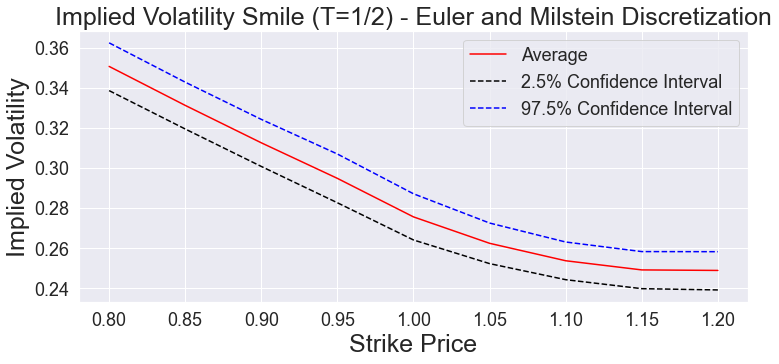

In [34]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) - Euler and Milstein Discretization')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [35]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation1_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

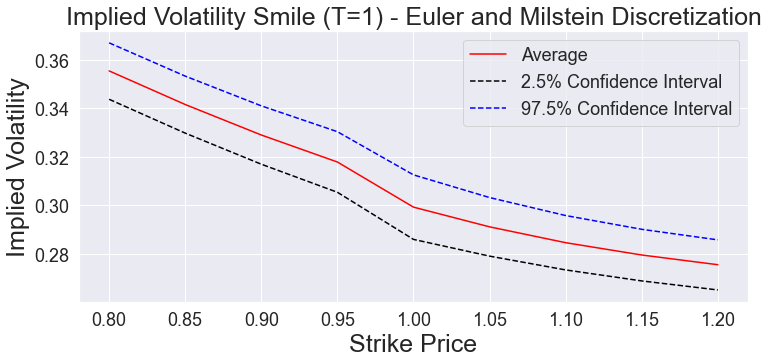

In [36]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) - Euler and Milstein Discretization')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

* Method 2: Newton Method

In [37]:
# with confidence intervals
def IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    St, vt, t = HeMC1(S0,v0,rho,kappa,theta,eta,T,Nsims)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            payoff = np.maximum((strikes[i]-St[:,-1]),0)
            
            option_mkt_price[i] = np.mean(payoff)
            option_mkt_price_lower[i] = np.mean(payoff) - 1.96*np.std(payoff)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(payoff) + 1.96*np.std(payoff)/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)

    
        elif strikes[i] >= S0:
            # call option
            payoff = np.maximum((St[:,-1]-strikes[i]),0)
            option_mkt_price[i] = np.mean(payoff)
            option_mkt_price_lower[i] = np.mean(payoff) - 1.96*np.std(payoff)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(payoff) + 1.96*np.std(payoff)/np.sqrt(Nsims)
            
            # calculate call price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
                
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [38]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

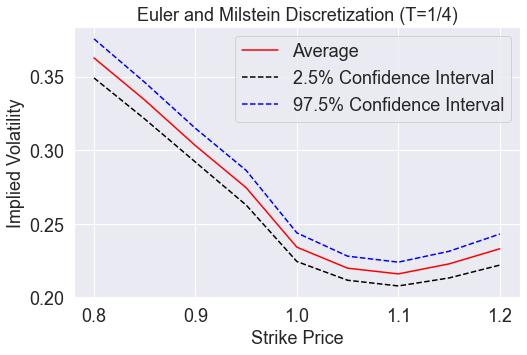

In [39]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Euler and Milstein Discretization (T=1/4)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [40]:
conf_width1=implied_volatility_upper-implied_volatility_lower
conf_width1

array([0.02654687, 0.02488195, 0.02292573, 0.02353738, 0.0194367 ,
       0.01634695, 0.01617099, 0.01811068, 0.02109562])

In [41]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

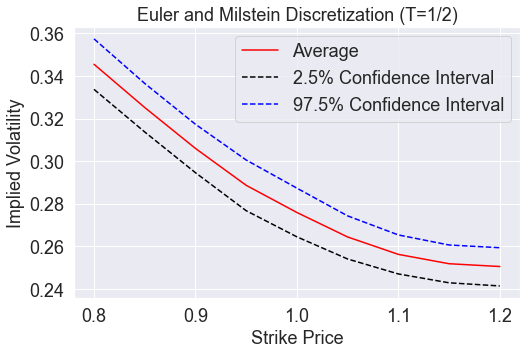

In [42]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Euler and Milstein Discretization (T=1/2)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [43]:
conf_width2=implied_volatility_upper-implied_volatility_lower
conf_width2

array([0.0237279 , 0.02280338, 0.02274959, 0.02382033, 0.02287802,
       0.0202557 , 0.01832796, 0.0177577 , 0.01796327])

In [44]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

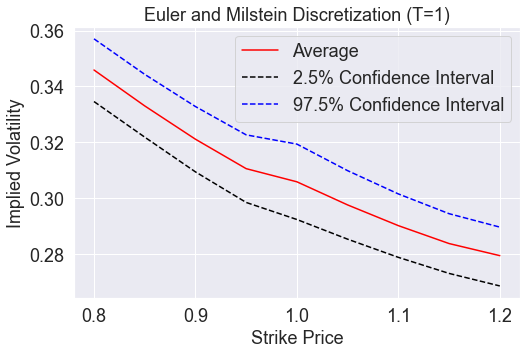

In [45]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Confidence Interval",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Confidence Interval",color="blue",linestyle="dashed")
plt.title('Euler and Milstein Discretization (T=1)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [46]:
conf_width3=implied_volatility_upper-implied_volatility_lower
conf_width3

array([0.02243194, 0.02246327, 0.02337301, 0.02418337, 0.02697988,
       0.02451334, 0.02269516, 0.02136967, 0.02104984])

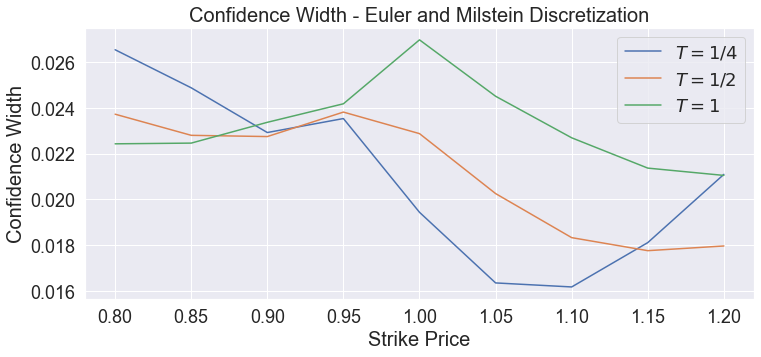

In [47]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width1,label = r"$T=1/4$")
plt.plot(strikes, conf_width2,label = r"$T=1/2$")
plt.plot(strikes, conf_width3,label = r"$T=1$")
plt.title('Confidence Width - Euler and Milstein Discretization',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

## 1.2 Mixing Method 

The second approach to estimate the implied volatility smiles is mixing method. This approach is to first use Milstein discretization of variance process $v_t$ and define a brownian motion that is independent with $W_v$. The asset price Brownian motion can then be written as the combination of the independent brownian motion and $W_v$. In mathematical terms, I first define $Z = \frac{W^S - \rho W^v}{\sqrt{1-\rho^2}}$ and then I could write $W^S$ in terms of $W^v$ and $Z$:
\begin{equation}\label{W_S}
    W^S = \rho W^v + \sqrt{1-\rho^2}Z
\end{equation}

As mentioned in the above section, the increment of log asset price can be written as 

\begin{align*}
    dx_t &=  -\frac{1}{2} v_tdt+\sqrt{v_t}\ dW_t^S\\
\end{align*}

Replacing the $W^S$ with the expression involving $W^v$ and $Z$, we can get the increment as:

\begin{align*}
    dx_t &= (-\frac{1}{2} v_tdt+\sqrt{v_t}\sqrt{1-\rho^2}\ dZ_t) +\sqrt{v_t}\cdot\rho\ dW_t^v
\end{align*}

In this way, the log asset price process can be considered as a normal distribution or equvilently speaking, we can write the asset price as a log normal process including the variance process:

\begin{equation}\label{mixing distribution}
    S_T \overset{d}{=}\widetilde{S_0} \cdot e^{-\frac{1}{2}b^2+bZ^*}
\end{equation}

where $\widetilde{S_0} = S_0\cdot e^{a+\frac{1}{2}b^2}$, $a=-\frac{1}{2}\int_0^T v_u\ du+\rho\int_0^T\sqrt{v_u}\ dW_u^v$, $b^2=(1-\rho^2)\int_0^Tv_u\ du$ and $Z^*\overset{\mathbb{Q}_Z}{\sim}\mathcal{N}(0,1)$

Compare with the Black-Scholes Option formula, I can obtain the call option and put option price using this mixing method:

\begin{align}
    C=E^{\mathbb{Q}}[(S_T-K)_+] &= \widetilde{S_0}\Phi(d_+) - K\Phi(d_-) \label{mixing call}\\
    P=E^{\mathbb{Q}}[(K-S_T)_+] &= -\widetilde{S_0}\Phi(-d_+) + K\Phi(-d_-) \label{mixing put}
\end{align}
where $d_{\pm} = \frac{\log{(\widetilde{S_0} / K)}\pm 0.5b^2}{b}$.

With the above analysis, I can simulate the sample paths of the variance process $v_t$ via Milstein discretization and then use these sample paths to calculate the option prices based on the newly derived asset price model.

### 1.2.1 Implied Volatility with Different Maturities

Use analytical solution to calculate the option price

In [48]:
def f_call(K, S, b ): 
    dp = (np.log(S/K) + 0.5*b**2)/b
    dm = (np.log(S/K) - 0.5*b**2)/b
    
    return S*norm.cdf(dp) - K*norm.cdf(dm)

def f_put(K, S, b ): 
    dp = (np.log(S/K) + 0.5*b**2)/b
    dm = (np.log(S/K) - 0.5*b**2)/b
    
    return K*norm.cdf(-dm) - S*norm.cdf(-dp)

Calculate the implied volatility, with market option price obtained from the analytical solution

In [49]:
# simulate sample paths of variance process
def sim_vt(v0, kappa, theta,eta,T,Nsims):
    
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
   
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*Z + 0.25*eta**2*(Z**2-1)*dt
    
    return vt, t

In [50]:
vt, t = sim_vt(v0, kappa, theta,eta,T=1,Nsims=5000)

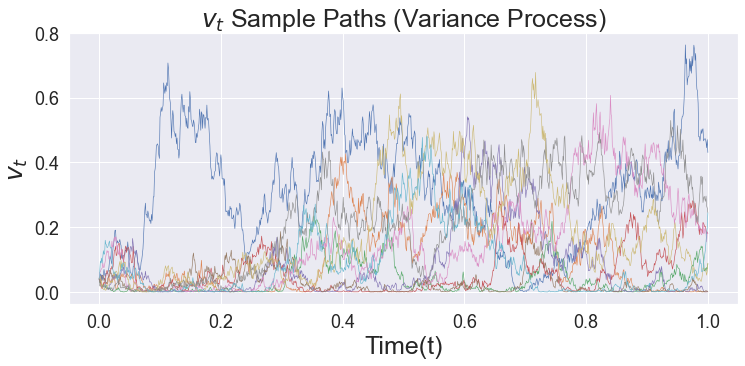

In [51]:
plt.figure(figsize=(12,5))
for i in range(0,10):
    plt.plot(t,vt[i,:],linewidth=0.6)
plt.title(r'$v_t$ Sample Paths (Variance Process)')
plt.xlabel('Time(t)')
plt.ylabel(r'$v_t$')
plt.show()

* Mibian method to calculate implied volatility using the Heston Model derived Black-Scholes Model

In [52]:
def MixS0(eta, kappa, theta, rho, Nsims,T):
    
    # time grid
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims,NdT))
    vt[:,0] = v0
    
    increment_vt = np.zeros((Nsims, NdT))
    
    increment_sqrtvt = np.zeros((Nsims,NdT))
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
        
        vt[:,i+1] = vt[:,i] + kappa*(theta-vt[:,i])*dt + eta*np.sqrt(vt[:,i]*dt)*Z+0.25*eta**2*(Z**2-1)*dt
        
        vt[:,i+1] = np.fmax(0,vt[:,i+1])
        
        increment_vt[:,i+1] = vt[:,i]*dt
        
        increment_sqrtvt[:,i+1] = np.sqrt(vt[:,i]) * sqrt_dt * Z
    
    integral_vt = np.sum(increment_vt, axis=1)
    integral_sqrtvt = np.sum(increment_sqrtvt, axis=1)
    
    # calculate a&b
    a = -0.5*integral_vt + rho*integral_sqrtvt
    b_squared = (1-rho**2)*integral_vt
    
    # new starting price for BS equation
    S0_star = S0*np.exp(a+0.5*b_squared)
    
    return S0_star, b_squared, a

In [53]:
S0_star, b_squared, a1 = MixS0(eta, kappa, theta, rho, Nsims=5000,T=1/4)

In [54]:
# without confidence intervals
# mibian method to calculate the implied volatility
def IV_mixing1(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)

    S0_star, b_squared,a = MixS0(eta, kappa, theta, rho, Nsims,T)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            # put option
            option_mkt_price[i] = np.mean(f_put(strikes[i],S0_star,np.sqrt(b_squared)))
            
            # calculate put price implied volatility
            p = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price[i])
            implied_volatility[i] = p.impliedVolatility
    
        elif strikes[i] >= S0:
            # call option
            option_mkt_price[i] = np.mean(f_call(strikes[i],S0_star,np.sqrt(b_squared)))
            
            # calculate call price implied volatility
            c = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price[i])    
            implied_volatility[i] = c.impliedVolatility
    
    return option_mkt_price, strikes, implied_volatility

In [55]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_mixing1(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_mixing1(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_mixing1(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

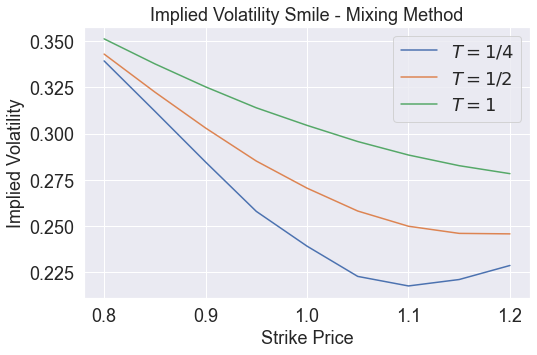

In [56]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter/100,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear/100,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year/100,label = r"$T=1$")
plt.title('Implied Volatility Smile - Mixing Method',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

### 1.2.2 Implied Volatility with Confidence Interval

* Mibian Method to Calculate the Confidence Interval

Note: it seems Mibian package and Newton's method can be used interchangeably, but it appears the Mibian's IV curve is more smooth

In [57]:
# with confidence intervals
def IV_mixing1_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    # obtain the input for new BS equations
    S0_star, b_squared,a = MixS0(eta, kappa, theta, rho, Nsims,T)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            
            # put option
            option_prices = f_put(strikes[i],S0_star,np.sqrt(b_squared))
            option_mkt_price[i] = np.mean(option_prices)
            option_mkt_price_lower[i] = np.mean(option_prices) - 1.96*np.std(option_prices)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(option_prices) + 1.96*np.std(option_prices)/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            p1 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price[i])
            implied_volatility[i] = p1.impliedVolatility
            p2 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price_lower[i])
            implied_volatility_lower[i] = p2.impliedVolatility
            p3 = mibian.BS([S0,strikes[i],0,T*365], putPrice=option_mkt_price_upper[i])
            implied_volatility_upper[i] = p3.impliedVolatility

        elif strikes[i] >= S0:
            
            # call option
            option_prices = f_call(strikes[i],S0_star,np.sqrt(b_squared))
            option_mkt_price[i] = np.mean(option_prices)
            option_mkt_price_lower[i] = np.mean(option_prices) - 1.96*np.std(option_prices)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(option_prices) + 1.96*np.std(option_prices)/np.sqrt(Nsims)
            
            # calculate call price implied volatility
            c1 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price[i])
            implied_volatility[i] = c1.impliedVolatility
            c2 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price_lower[i])
            implied_volatility_lower[i] = c2.impliedVolatility
            c3 = mibian.BS([S0,strikes[i],0,T*365], callPrice=option_mkt_price_upper[i])
            implied_volatility_upper[i] = c3.impliedVolatility
                
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [58]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing1_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

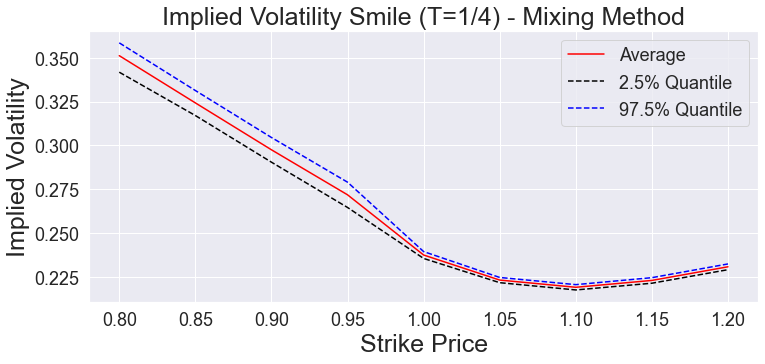

In [59]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) - Mixing Method')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [60]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing1_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

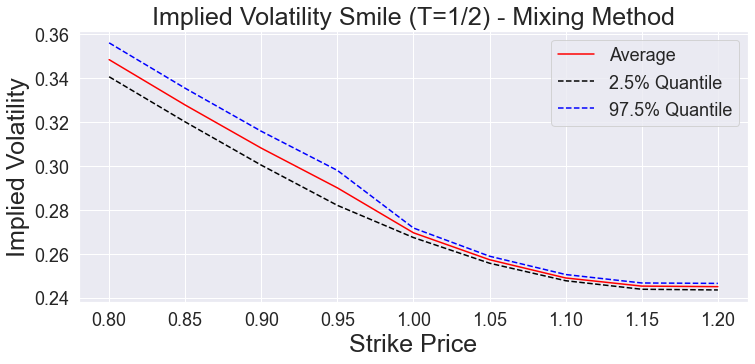

In [61]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) - Mixing Method')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [62]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing1_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

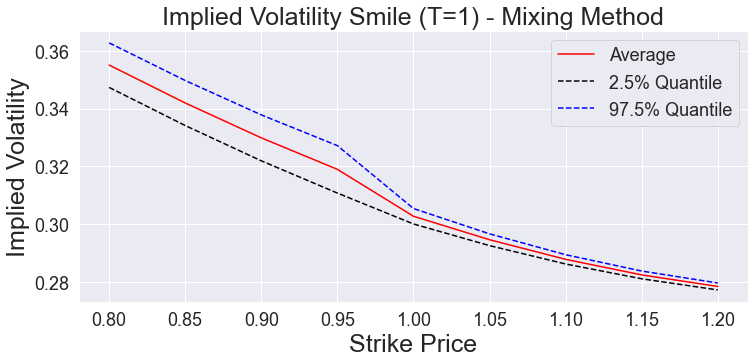

In [63]:
plt.figure(figsize=(12,5))
plt.plot(strikes, implied_volatility/100,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower/100,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper/100,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) - Mixing Method')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

* Newton Method to Calculate the confidence interval

In [64]:
# with confidence intervals
def IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    strikes = np.arange(0.8,1.25,0.05)
    
    # obtain the input for new BS equations
    S0_star, b_squared,a = MixS0(eta, kappa, theta, rho, Nsims,T)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
    
        if strikes[i] < S0:
            
            # put option
            option_prices = f_put(strikes[i],S0_star,np.sqrt(b_squared))
            option_mkt_price[i] = np.mean(option_prices)
            option_mkt_price_lower[i] = np.mean(option_prices) - 1.96*np.std(option_prices)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(option_prices) + 1.96*np.std(option_prices)/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
       
        elif strikes[i] >= S0:
            
            # call option
            option_prices = f_call(strikes[i],S0_star,np.sqrt(b_squared))
            option_mkt_price[i] = np.mean(option_prices)
            option_mkt_price_lower[i] = np.mean(option_prices) - 1.96*np.std(option_prices)/np.sqrt(Nsims)
            option_mkt_price_upper[i] = np.mean(option_prices) + 1.96*np.std(option_prices)/np.sqrt(Nsims)
            
            # calculate call price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
                
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [65]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

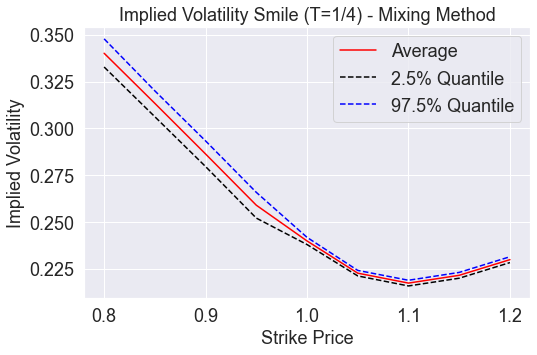

In [66]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) - Mixing Method',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [67]:
conf_width4=implied_volatility_upper-implied_volatility_lower
conf_width4

array([0.01504163, 0.01381526, 0.0136938 , 0.01375935, 0.00383444,
       0.00295268, 0.00303471, 0.00310162, 0.00311829])

In [68]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

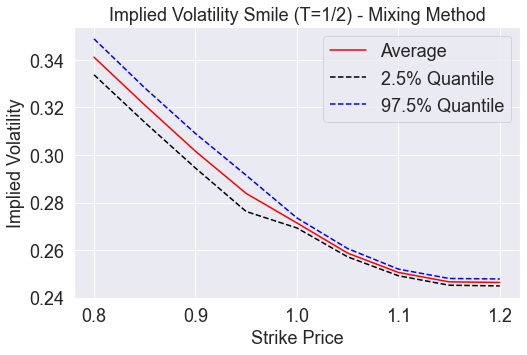

In [69]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) - Mixing Method',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [70]:
conf_width5=implied_volatility_upper-implied_volatility_lower
conf_width5

array([0.01510967, 0.01451337, 0.01454519, 0.0152351 , 0.00421566,
       0.00348551, 0.00279071, 0.00282993, 0.00293444])

In [71]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

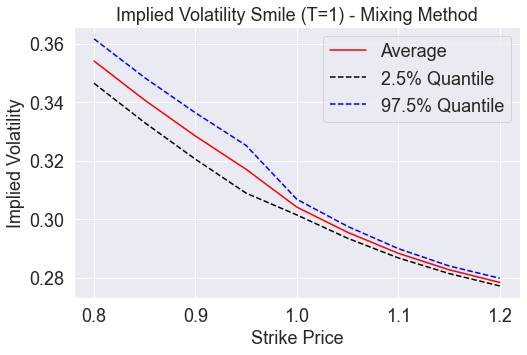

In [72]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) - Mixing Method',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [73]:
conf_width6=implied_volatility_upper-implied_volatility_lower
conf_width6

array([0.01517607, 0.01537019, 0.01585551, 0.0162872 , 0.00533449,
       0.0040648 , 0.00316945, 0.00260445, 0.00262844])

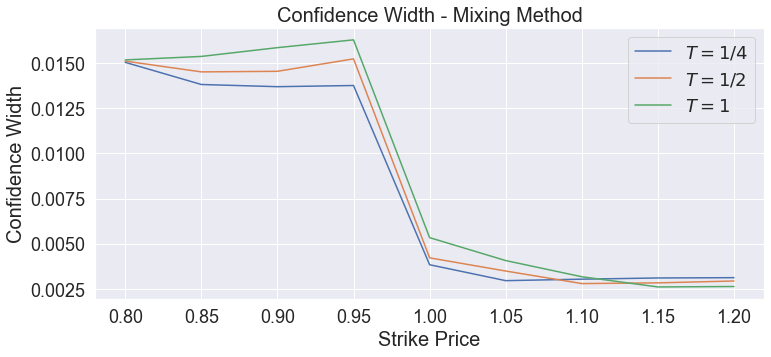

In [74]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width4,label = r"$T=1/4$")
plt.plot(strikes, conf_width5,label = r"$T=1/2$")
plt.plot(strikes, conf_width6,label = r"$T=1$")
plt.title('Confidence Width - Mixing Method',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

# 2. Implementation of Control Variates

A control variate is a technique to reduce the variance of Monte Carlo simulation which allows analysts to estimate the expectation of one random variable when they know the analytical solution of one or several closely related random variables (i.e. so called control variates). Suppose $X$ and $Y_1,\dots,Y_m$ are random variables and $(X^{(n)},Y_1^{(n)},\dots,Y_m^{(n)})_{n=1,\dots,N}$ are the Monte Carlo simulations of $X$ and $Y_1,\dots,Y_m$. The control variates method claims that we are able to estimate $g=\mathbb{E}(X)$ if we know the analytical results for $h_i = \mathbb{E}(Y_i)$, $i=1,\dots,m$, such that

\begin{equation}\label{control variate}
    \hat g = \frac{1}{N}\sum_{n=1}^N X^{(n)} + \sum_{i=1}^m \gamma_i \left( h_i-\frac{1}{N}\sum_{n=1}^{N}Y_i^{(n)} \right)
\end{equation}
where $(\gamma_i)_{i=1,\dots,N}$ are arbitrary constants.

If there is only one control variate, the optimal choice of $\gamma$ is $\frac{Cov[X, Y]}{Var[Y]}$.

First, I'd like to implement four seperate control variables to reduce the Monte Carlo simulations.

## 2.1 Deterministic Volatility Model

The first control variate I have considered is the value of a contigent claim paying $\int_0^T v_sds$ at maturity $T$.

First, I'd like to replace the stochastic variance process with a deterministic volatility model by replacing the $v_t$ with $\bar{v}_t = \mathbb{E}[v_t]$.

The time-dependent mean of the variance process can be derived to the following expression:

\begin{equation}
    \bar{v}_t = v_0 \cdot e^{-\kappa t} + \theta\cdot(1-e^{-\kappa t})
\end{equation}

The option price then using the time-dependent mean of the variance process is then determined to be:

\begin{align*}
    V_0^{\text{call}} &= S_0\Phi(d_+) - K\Phi(d_-)\\
    V_0^{\text{put}} &= -S_0\Phi(-d_+) + K\Phi(-d_-)
\end{align*}
where $d_{\pm} = \frac{\log(S_0/K)\pm\frac{1}{2}c}{\sqrt{c}}$ and $c=\int_0^T\bar{v}_udu$.

Here I'd like to show the stock preice path generated using the Heston model and the deterministic volatility model.

In [75]:
def stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims):

    # time grid
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    # generate standard brownian motion for stock price process and variance process
    MU = np.array([0,0])
    COV = np.matrix([[1, rho],[rho,1]])
    e = np.random.multivariate_normal(MU,COV,size=(Nsims,t.shape[0]))
    e_S = e[:,:,0]
    e_v = e[:,:,1]
    
    # Heston Model variance process
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    # deterministic variance process
    vt_bar = np.zeros(NdT)
    vt_bar[0] = v0
    c = np.zeros(NdT)
    Xt_Y1 = np.zeros((Nsims,NdT))
    Xt_Y1[:,0] = np.log(S0)
    # Euler discretization of stock price process
    Xt = np.zeros((Nsims, NdT))
    Xt[:,0] = np.log(S0)
    # correction ofr Milstein discretization
    correction = 0.25*eta**2*(e_v**2-1)*dt
    
    for i in range(len(t)-1):
        
        # Milstein discretization of vt
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*e_v[:,i] + correction[:,i]
        
        # Euler discretization of Xt
        Xt[:,i+1] = Xt[:,i] - 0.5*np.maximum(vt[:,i],0)*dt + np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*e_S[:,i]
                
        # Deterministic variance process
        vt_bar[i+1] = v0*np.exp(-kappa*t[i+1]) + theta*(1-np.exp(-kappa*t[i+1]))
        
        # Deterministic variance process based stock price process
        c[i+1] = (v0-theta)*(1-np.exp(-kappa*t[i+1]))/kappa + theta*t[i+1]
        Xt_Y1[:,i+1] = Xt_Y1[:,i]-0.5*vt_bar[i]*dt + np.sqrt(vt_bar[i])*sqrt_dt*e_S[:,i]
        
    St = np.exp(Xt)
    St_Y1 = np.exp(Xt_Y1)
    
    return t, St, St_Y1

In [76]:
t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

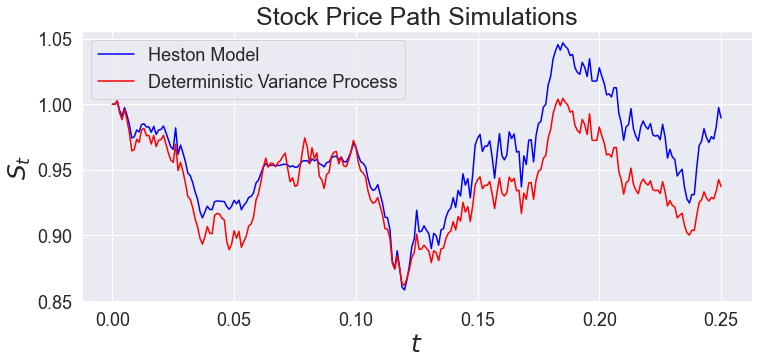

In [77]:
plt.figure(figsize=(12,5))
plt.plot(t,St[1,:],color='blue',label='Heston Model')
plt.plot(t,St_Y1[1,:],color='red',label='Deterministic Variance Process')
plt.title('Stock Price Path Simulations')
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.legend()
plt.show()

In [78]:
t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)

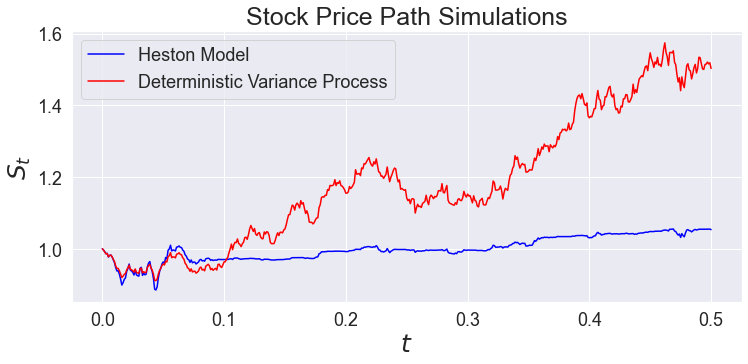

In [79]:
plt.figure(figsize=(12,5))
plt.plot(t,St[1,:],color='blue',label='Heston Model')
plt.plot(t,St_Y1[1,:],color='red',label='Deterministic Variance Process')
plt.title('Stock Price Path Simulations')
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.legend()
plt.show()

In [80]:
t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

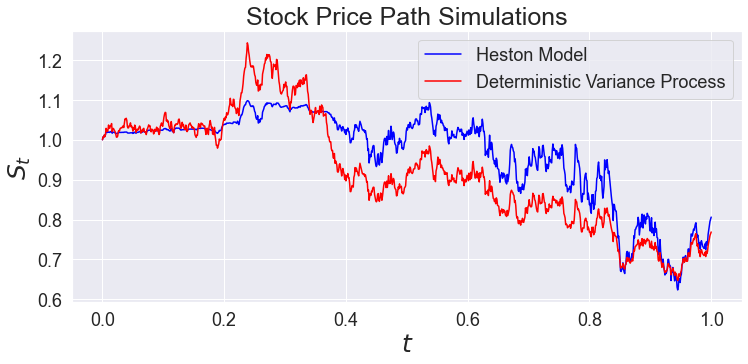

In [81]:
plt.figure(figsize=(12,5))
plt.plot(t,St[1,:],color='blue',label='Heston Model')
plt.plot(t,St_Y1[1,:],color='red',label='Deterministic Variance Process')
plt.title('Stock Price Path Simulations')
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.legend()
plt.show()

## 2.2 Control Variate Type 1

The first control variate type I use is the option price determined using the deterministic variance path.

In [82]:
def IV_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y1 = np.maximum((strikes[i]-St_Y1[:,-1]),0)
            gamma1 = np.cov(payoff_X,payoff_Y1)[0,1] / np.var(payoff_Y1)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = strikes[i]*norm.cdf(-dm) - S0*norm.cdf(-dp)
            option_mkt_price[i] = np.mean(payoff_X) + gamma1*(h1-np.mean(payoff_Y1))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)

        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y1 = np.maximum((St_Y1[:,-1]-strikes[i]),0)
            gamma1 = np.cov(payoff_X,payoff_Y1)[0,1] / np.var(payoff_Y1)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = S0*norm.cdf(dp) - strikes[i]*norm.cdf(dm)
            option_mkt_price[i] = np.mean(payoff_X) + gamma1*(h1-np.mean(payoff_Y1))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
        
    return option_mkt_price, strikes, implied_volatility

In [83]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_control_variate1(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_control_variate1(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_control_variate1(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

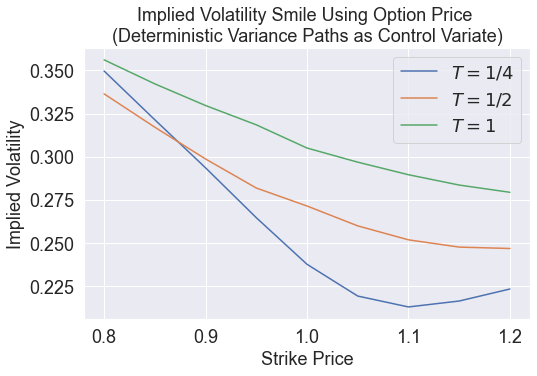

In [84]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile Using Option Price \n(Deterministic Variance Paths as Control Variate)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [85]:
def IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y1 = np.maximum((strikes[i]-St_Y1[:,-1]),0)
            gamma1 = np.cov(payoff_X,payoff_Y1)[0,1] / np.var(payoff_Y1)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = strikes[i]*norm.cdf(-dm) - S0*norm.cdf(-dp)
            option_mkt_price[i] = np.mean(payoff_X) + gamma1*(h1-np.mean(payoff_Y1))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y1)[0,1]**2/np.var(payoff_Y1))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y1 = np.maximum((St_Y1[:,-1]-strikes[i]),0)
            gamma1 = np.cov(payoff_X,payoff_Y1)[0,1] / np.var(payoff_Y1)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = S0*norm.cdf(dp) - strikes[i]*norm.cdf(dm)
            option_mkt_price[i] = np.mean(payoff_X) + gamma1*(h1-np.mean(payoff_Y1))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y1)[0,1]**2/np.var(payoff_Y1))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)      
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [86]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

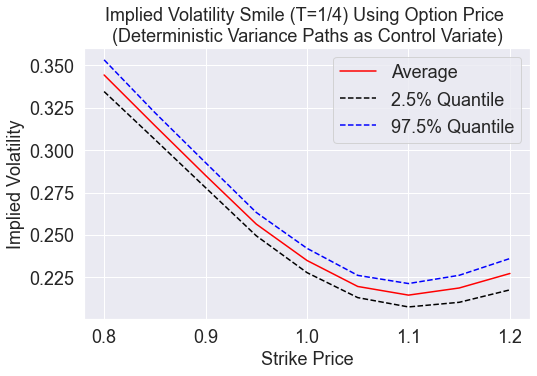

In [87]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) Using Option Price \n(Deterministic Variance Paths as Control Variate)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [88]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

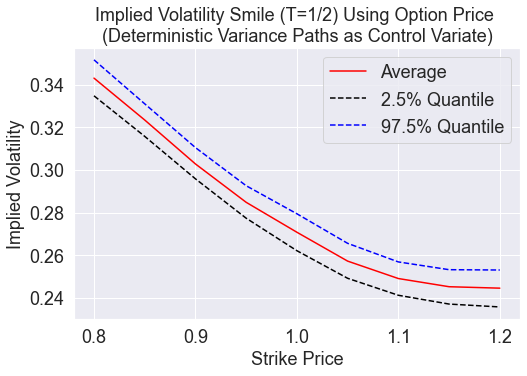

In [89]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) Using Option Price \n(Deterministic Variance Paths as Control Variate)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [90]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

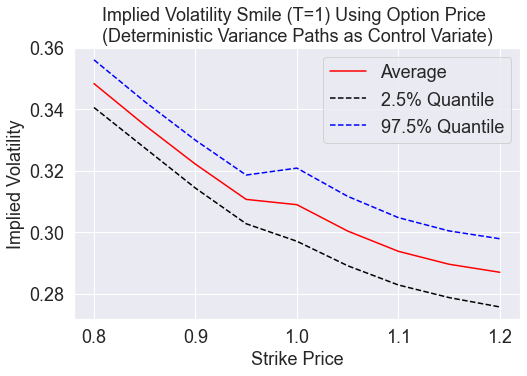

In [91]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) Using Option Price \n(Deterministic Variance Paths as Control Variate)',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

## 2.3 Value of the Contingent Claim Paying $\int_{0}^{T} v_s\,ds$ 

First, I derive the analytical expression of this claim. Since the option price is equal to the expectation of the payoff, the value of the claim is then can be written as 

\begin{align}
    V &= \mathbb{E}[\int_0^T v_sds] = \int_0^T \mathbb{E}[v_s]ds = \int_0^T \bar{v}_sds\nonumber\\
     &= \frac{(v_0-\theta)(1-e^{-\kappa T})}{\kappa} + \theta T \label{analytical formula claim 1}
\end{align}

Then, I simulate the claim price using Milstein discretization and calculate the price analytically. Compare the simulations with analytical results

In [92]:
# simulate sample paths of variance process
def sim_vt_price(v0, kappa, theta,eta,T,Nsims):
    
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
   
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*Z + 0.25*eta**2*(Z**2-1)*dt
    
    # simulated price of claim
    V_sim = np.zeros(NdT)
    integrate_vt = np.cumsum(vt*dt, axis=1)
    for i in range(1,len(t)):
        V_sim[i] = np.mean(integrate_vt[:,i-1],axis=0)
        
    # calculate the analytical price of the claims
    V_analytical = np.zeros(NdT)
    for i in range(len(t)):
        V_analytical[i] = (v0-theta)*(1-np.exp(-kappa*t[i]))/kappa + theta*t[i]
    
    return t, V_sim, V_analytical

In [93]:
t, V_sim, V_analytical = sim_vt_price(v0, kappa, theta,eta,T=1,Nsims=5000)

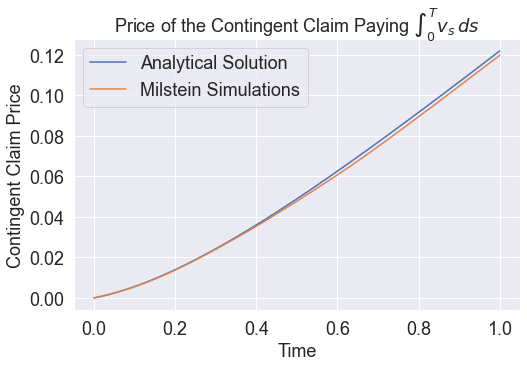

In [94]:
plt.figure(figsize=(8,5))
plt.plot(t,V_analytical,label="Analytical Solution")
plt.plot(t,V_sim,label="Milstein Simulations")
plt.title(r'Price of the Contingent Claim Paying $\int_{0}^{T} v_s\,ds$',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Contingent Claim Price',fontsize=18)
plt.legend()
plt.show()

## 2.4 Control Variate Type 2

Here I use the claim paying $\int_{0}^{T} v_s\,ds$ as the control variate

In [95]:
def PayoffY2(v0, kappa, theta,eta,T,Nsims):
    
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
   
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*Z + 0.25*eta**2*(Z**2-1)*dt
    
    # simulated price of claim
    V_sim = np.zeros((Nsims,NdT))
    
    integrate_vt = np.cumsum(vt*dt, axis=1)
    for i in range(1,len(t)):
        V_sim[:,i] = integrate_vt[:,i-1]
    
    # calculate the analytical price of the claims
    V_analytical = np.zeros(NdT)
    for i in range(len(t)):
        V_analytical[i] = (v0-theta)*(1-np.exp(-kappa*t[i]))/kappa + theta*t[i]
    
    return V_sim[:,-1], V_analytical[-1]

In [96]:
payoff_Y2, h2 = PayoffY2(v0, kappa, theta,eta,T=1/4,Nsims=5000)

In [97]:
def IV_control_variate2(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y2)[0,1] / np.var(payoff_Y2)
            option_mkt_price[i] = np.mean(payoff_X) + gamma2*(h2-np.mean(payoff_Y2))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)

        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y2)[0,1] / np.var(payoff_Y2)
            option_mkt_price[i] = np.mean(payoff_X) + gamma2*(h2-np.mean(payoff_Y2))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
        
    return option_mkt_price, strikes, implied_volatility

In [98]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_control_variate2(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_control_variate2(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_control_variate2(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

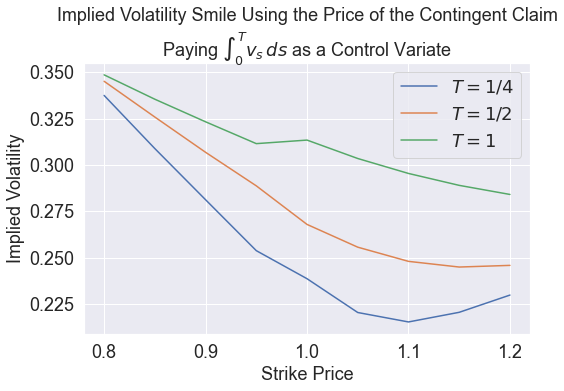

In [99]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile Using the Price of the Contingent Claim'+'\n'+r'Paying $\int_{0}^{T} v_s\,ds$ as a Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [100]:
def IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y2)[0,1] / np.var(payoff_Y2)
            option_mkt_price[i] = np.mean(payoff_X) + gamma2*(h2-np.mean(payoff_Y2))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y2)[0,1]**2/np.var(payoff_Y2))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y2)[0,1] / np.var(payoff_Y2)
            option_mkt_price[i] = np.mean(payoff_X) + gamma2*(h2-np.mean(payoff_Y2))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y2)[0,1]**2/np.var(payoff_Y2))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)      
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [101]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

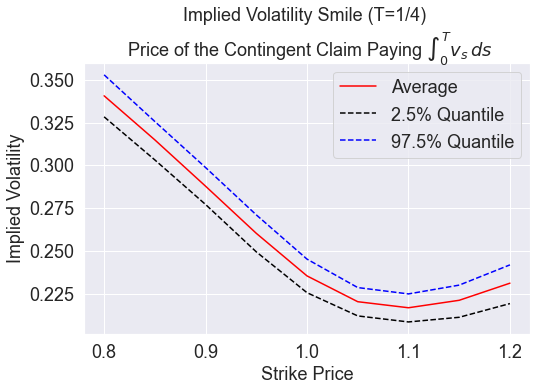

In [102]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) \n Price of the Contingent Claim Paying $\int_{0}^{T} v_s\,ds$',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [103]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

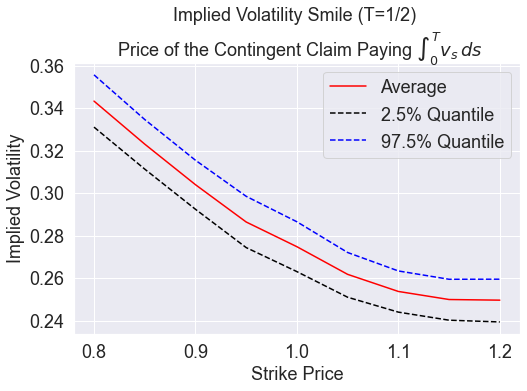

In [104]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) \n Price of the Contingent Claim Paying $\int_{0}^{T} v_s\,ds$',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [105]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

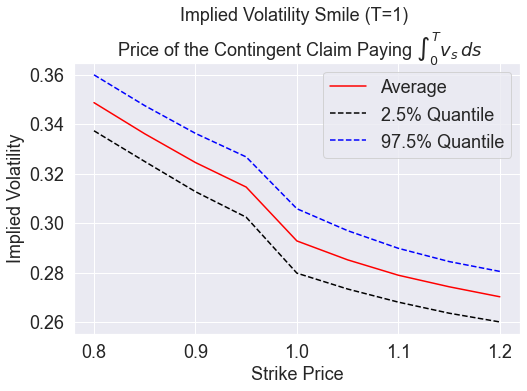

In [106]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) \n Price of the Contingent Claim Paying $\int_{0}^{T} v_s\,ds$',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

# Q2(b)-iii-Value of the Contingent Claim Paying $\int_{0}^{T} v_s^2\,ds$ 

Simulate the claim price using Milstein simulations and calculate the price analytically. Compare the simulation with analytical

In [ ]:
# simulate sample paths of variance process
def sim_vt_price(v0, kappa, theta,eta,T,Nsims):
    
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
   
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*Z + 0.25*eta**2*(Z**2-1)*dt
    
    # simulated price of claim
    V_sim = np.zeros(NdT)
    integrate_vt = np.cumsum(vt**2*dt, axis=1)
    for i in range(1,len(t)):
        V_sim[i] = np.mean(integrate_vt[:,i-1],axis=0)
        
    # calculate the analytical price of the claims
    V_analytical = np.zeros(NdT)
    for i in range(len(t)):
        V_analytical[i] = -0.0074*(np.exp(-2*3*t[i])-1)+0.0428*(np.exp(-3*t[i])-1)+0.0856*t[i]
    
    return t, V_sim, V_analytical

In [ ]:
t, V_sim, V_analytical = sim_vt_price(v0, kappa, theta,eta,T=1,Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(t,V_analytical,label="Analytical Solution")
plt.plot(t,V_sim,label="Milstein Simulations")
plt.title(r'Price of the Contingent Claim Paying $\int_{0}^{T} v_s^2\,ds$',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.legend()
plt.show()

Verify the analytical ODE solution

In [ ]:
# last part
(2*kappa*theta+eta**2)*theta/(2*kappa)

In [ ]:
# second part coefficient
(2*kappa*theta+eta**2)*(v0-theta)/kappa

In [ ]:
# first part coefficient
v0**2-(1/kappa)*(2*kappa*theta+eta**2)*(v0-theta)-1/(2*kappa)*(2*kappa*theta+eta**2)*theta

# Q2(c)-i-C-Implied Volatility Calc. Using the Contingent Claim Paying $\int_{0}^{T} v_s^2\,ds$ as Control Variate

In [ ]:
def PayoffY3(v0, kappa, theta,eta,T,Nsims):
    
    NdT = int(T/(1/1000)+1)
    t = np.linspace(0,T,NdT)
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    
    vt = np.zeros((Nsims, NdT))
    vt[:,0] = v0
    
    for i in range(len(t)-1):
        
        Z = np.random.randn(Nsims)
   
        vt[:,i+1] = vt[:,i] + kappa*(theta-np.maximum(vt[:,i],0))*dt + eta*np.sqrt(np.maximum(vt[:,i],0))*sqrt_dt*Z + 0.25*eta**2*(Z**2-1)*dt
    
    # simulated price of claim
    V_sim = np.zeros((Nsims,NdT))
    
    integrate_vt = np.cumsum(vt**2*dt, axis=1)
    for i in range(1,len(t)):
        V_sim[:,i] = integrate_vt[:,i-1]
    
    # calculate the analytical price of the claims
    V_analytical = np.zeros(NdT)
    for i in range(len(t)):
        V_analytical[i] = -0.0074*(np.exp(-2*3*t[i])-1)+0.0428*(np.exp(-3*t[i])-1)+0.0856*t[i]
    
    return V_sim[:,-1], V_analytical[-1]

In [ ]:
def IV_control_variate3(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            gamma3 = np.cov(payoff_X,payoff_Y3)[0,1] / np.var(payoff_Y3)
            option_mkt_price[i] = np.mean(payoff_X) + gamma3*(h3-np.mean(payoff_Y3))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)

        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y3,h3 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y3)[0,1] / np.var(payoff_Y3)
            option_mkt_price[i] = np.mean(payoff_X) + gamma3*(h3-np.mean(payoff_Y3))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
        
    return option_mkt_price, strikes, implied_volatility

In [ ]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_control_variate3(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_control_variate3(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_control_variate3(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile Using Price of the Contingent Claim'+'\n'+r'Paying $\int_{0}^{T} v_s^2\,ds$ as a Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
def IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            gamma2 = np.cov(payoff_X,payoff_Y3)[0,1] / np.var(payoff_Y3)
            option_mkt_price[i] = np.mean(payoff_X) + gamma2*(h2-np.mean(payoff_Y3))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y3)[0,1]**2/np.var(payoff_Y3))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            payoff_Y3,h3 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            gamma3 = np.cov(payoff_X,payoff_Y3)[0,1] / np.var(payoff_Y3)
            option_mkt_price[i] = np.mean(payoff_X) + gamma3*(h2-np.mean(payoff_Y3))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,payoff_Y3)[0,1]**2/np.var(payoff_Y3))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)      
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) Price of the Contingent Claim'+'\n'+r'Paying $\int_{0}^{T} v_s^2\,ds$ as a Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) Price of the Contingent Claim'+'\n'+r'Paying $\int_{0}^{T} v_s^2\,ds$ as a Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) Price of the Contingent Claim'+'\n'+r'Paying $\int_{0}^{T} v_s^2\,ds$ as a Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

# Q2.(c)-i-D Implied Volatility Calc. Using Stock as Control Variate

Implied volatilities for different maturities

In [ ]:
def IV_control_variate4(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            Y4 = St[:,-1]
            gamma4 = np.cov(payoff_X,Y4)[0,1] / np.var(Y4)
            h4 = S0
            option_mkt_price[i] = np.mean(payoff_X) + gamma4*(h4-np.mean(Y4))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)

        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            Y4 = St[:,-1]
            gamma4 = np.cov(payoff_X,Y4)[0,1] / np.var(Y4)
            h4 = S0
            option_mkt_price[i] = np.mean(payoff_X) + gamma4*(h4-np.mean(Y4))
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
        
    return option_mkt_price, strikes, implied_volatility

In [ ]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_control_variate4(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_control_variate4(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_control_variate4(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile Using Stock Price as Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
def IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)
    
    strikes = np.arange(0.8,1.25,0.05)
    
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):
        
        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            Y4 = St[:,-1]
            gamma4 = np.cov(payoff_X,Y4)[0,1] / np.var(Y4)
            h4 = S0
            option_mkt_price[i] = np.mean(payoff_X) + gamma4*(h4-np.mean(Y4))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,Y4)[0,1]**2/np.var(Y4))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            # call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            Y4 = St[:,-1]
            gamma4 = np.cov(payoff_X,Y4)[0,1] / np.var(Y4)
            h4 = S0
            option_mkt_price[i] = np.mean(payoff_X) + gamma4*(h4-np.mean(Y4))
            std_deviation = np.sqrt(np.var(payoff_X)-np.cov(payoff_X,Y4)[0,1]**2/np.var(Y4))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)      
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) - Using Stock as Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) - Using Stock as Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) - Using Stock as Control Variate',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

# Q2.-(c)-ii Implied Volatility Calc. Using All Control Variates

In [ ]:
def IV_control_variate_all(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)

    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    for i in range(len(strikes)):

        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            # control variate 1 (deterministic variance process)
            payoff_Y1 = np.maximum((strikes[i]-St_Y1[:,-1]),0)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = strikes[i]*norm.cdf(-dm) - S0*norm.cdf(-dp)
            # control variate 2( the claim paying vs*ds )
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            # control variate 3( the claim paying vs**2*ds )
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            # control variate 4( stock )
            Y4 = St[:,-1]
            h4 = S0

            l11 = np.var(payoff_Y1)
            l12 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l13 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l14 = np.cov(payoff_Y1,Y4)[0,1]
            r1 = np.cov(payoff_X,payoff_Y1)[0,1]

            l21 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l22 = np.var(payoff_Y2)
            l23 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l24 = np.cov(payoff_Y2,Y4)[0,1]
            r2 = np.cov(payoff_X,payoff_Y2)[0,1]

            l31 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l32 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l33 = np.var(payoff_Y3)
            l34 = np.cov(payoff_Y3,Y4)[0,1]
            r3 = np.cov(payoff_X,payoff_Y3)[0,1]

            l41 = np.cov(payoff_Y1,Y4)[0,1]
            l42 = np.cov(payoff_Y2,Y4)[0,1]
            l43 = np.cov(payoff_Y3,Y4)[0,1]
            l44 = np.var(Y4)
            r4 = np.cov(payoff_X,Y4)[0,1]

            LHS = np.array([[l11,l12,l13,l14],[l21,l22,l23,l24],[l31,l32,l33,l34],[l41,l42,l43,l44]])
            RHS = np.array([r1,r2,r3,r4])

            gamma = np.linalg.solve(LHS,RHS)

            option_mkt_price[i] = np.mean(payoff_X) + gamma[0]*(h1-np.mean(payoff_Y1)) + gamma[1]*(h2-np.mean(payoff_Y2)) + gamma[2]*(h3-np.mean(payoff_Y3))+ gamma[3]*(h4 - np.mean(Y4))
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            #call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            # control variate 1 (deterministic variance process)
            payoff_Y1 = np.maximum((St_Y1[:,-1]-strikes[i]),0)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = S0*norm.cdf(dp) - strikes[i]*norm.cdf(dm)
            # control variate 2( the claim paying vs*ds )
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            # control variate 3( the claim paying vs**2*ds )
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            # control variate 4( stock )
            Y4 = St[:,-1]
            h4 = S0

            l11 = np.var(payoff_Y1)
            l12 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l13 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l14 = np.cov(payoff_Y1,Y4)[0,1]
            r1 = np.cov(payoff_X,payoff_Y1)[0,1]

            l21 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l22 = np.var(payoff_Y2)
            l23 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l24 = np.cov(payoff_Y2,Y4)[0,1]
            r2 = np.cov(payoff_X,payoff_Y2)[0,1]

            l31 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l32 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l33 = np.var(payoff_Y3)
            l34 = np.cov(payoff_Y3,Y4)[0,1]
            r3 = np.cov(payoff_X,payoff_Y3)[0,1]

            l41 = np.cov(payoff_Y1,Y4)[0,1]
            l42 = np.cov(payoff_Y2,Y4)[0,1]
            l43 = np.cov(payoff_Y3,Y4)[0,1]
            l44 = np.var(Y4)
            r4 = np.cov(payoff_X,Y4)[0,1]

            LHS = np.array([[l11,l12,l13,l14],[l21,l22,l23,l24],[l31,l32,l33,l34],[l41,l42,l43,l44]])
            RHS = np.array([r1,r2,r3,r4])

            gamma = np.linalg.solve(LHS,RHS)

            option_mkt_price[i] = np.mean(payoff_X) + gamma[0]*(h1-np.mean(payoff_Y1)) + gamma[1]*(h2-np.mean(payoff_Y2)) + gamma[2]*(h3-np.mean(payoff_Y3))+ gamma[3]*(h4 - np.mean(Y4))
            
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return option_mkt_price, strikes, implied_volatility

In [ ]:
option_mkt_price_quarter, strikes, implied_volatility_quarter = IV_control_variate_all(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)
option_mkt_price_halfyear, strikes, implied_volatility_halfyear = IV_control_variate_all(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)
option_mkt_price_year, strikes, implied_volatility_year = IV_control_variate_all(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility_quarter,label = r"$T=1/4$")
plt.plot(strikes, implied_volatility_halfyear,label = r"$T=1/2$")
plt.plot(strikes, implied_volatility_year,label = r"$T=1$")
plt.title('Implied Volatility Smile Using All Control Variates',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
def IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T, Nsims):
    
    t, St, St_Y1 = stock_control_variate1(S0, v0, rho, kappa, theta, eta, T, Nsims)

    strikes = np.arange(0.8,1.25,0.05)
    option_mkt_price = np.zeros(len(strikes))
    implied_volatility = np.zeros(len(strikes))
    
    # 2.5% confidence interval
    option_mkt_price_lower = np.zeros(len(strikes))
    implied_volatility_lower = np.zeros(len(strikes))
    
    # 97.5% confidence interval
    option_mkt_price_upper = np.zeros(len(strikes))
    implied_volatility_upper = np.zeros(len(strikes))
    
    for i in range(len(strikes)):

        if strikes[i] < S0:
            
            # put option
            payoff_X = np.maximum((strikes[i]-St[:,-1]),0)
            # control variate 1 (deterministic variance process)
            payoff_Y1 = np.maximum((strikes[i]-St_Y1[:,-1]),0)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = strikes[i]*norm.cdf(-dm) - S0*norm.cdf(-dp)
            # control variate 2( the claim paying vs*ds )
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            # control variate 3( the claim paying vs**2*ds )
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            # control variate 4( stock )
            Y4 = St[:,-1]
            h4 = S0

            l11 = np.var(payoff_Y1)
            l12 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l13 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l14 = np.cov(payoff_Y1,Y4)[0,1]
            r1 = np.cov(payoff_X,payoff_Y1)[0,1]

            l21 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l22 = np.var(payoff_Y2)
            l23 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l24 = np.cov(payoff_Y2,Y4)[0,1]
            r2 = np.cov(payoff_X,payoff_Y2)[0,1]

            l31 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l32 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l33 = np.var(payoff_Y3)
            l34 = np.cov(payoff_Y3,Y4)[0,1]
            r3 = np.cov(payoff_X,payoff_Y3)[0,1]

            l41 = np.cov(payoff_Y1,Y4)[0,1]
            l42 = np.cov(payoff_Y2,Y4)[0,1]
            l43 = np.cov(payoff_Y3,Y4)[0,1]
            l44 = np.var(Y4)
            r4 = np.cov(payoff_X,Y4)[0,1]

            LHS = np.array([[l11,l12,l13,l14],[l21,l22,l23,l24],[l31,l32,l33,l34],[l41,l42,l43,l44]])
            RHS = np.array([r1,r2,r3,r4])

            gamma = np.linalg.solve(LHS,RHS)
            std_deviation1 = np.var(payoff_X) + gamma[0]**2*np.var(payoff_Y1) + gamma[1]**2*np.var(payoff_Y2) + gamma[2]**2*np.var(payoff_Y3) + gamma[3]**2*np.var(Y4)
            std_deviation2 = -2*gamma[0]*np.cov(payoff_X,payoff_Y1)[0,1] -2*gamma[1]*np.cov(payoff_X,payoff_Y2)[0,1] -2*gamma[2]*np.cov(payoff_X,payoff_Y3)[0,1] -2*gamma[3]*np.cov(payoff_X,Y4)[0,1]
            std_deviation3 = 2*gamma[0]*gamma[1]*np.cov(payoff_Y1,payoff_Y2)[0,1] + 2*gamma[0]*gamma[2]*np.cov(payoff_Y1,payoff_Y3)[0,1] + 2*gamma[0]*gamma[3]*np.cov(payoff_Y1,Y4)[0,1]
            std_deviation4 = 2*gamma[1]*gamma[2]*np.cov(payoff_Y2,payoff_Y3)[0,1] + 2*gamma[1]*gamma[3]*np.cov(payoff_Y2,Y4)[0,1]
            std_deviation5 = 2*gamma[2]*gamma[3]*np.cov(payoff_Y3,Y4)[0,1]
            std_deviation = np.sqrt(std_deviation1 + std_deviation2 + std_deviation3 + std_deviation4 + std_deviation5)
            
            option_mkt_price[i] = np.mean(payoff_X) + gamma[0]*(h1-np.mean(payoff_Y1)) + gamma[1]*(h2-np.mean(payoff_Y2)) + gamma[2]*(h3-np.mean(payoff_Y3))+ gamma[3]*(h4 - np.mean(Y4))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate put price implied volatility
            implied_volatility[i] = implied_volatility_put(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_put(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_put(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
        elif strikes[i] >= S0:
            
            #call option
            payoff_X = np.maximum((St[:,-1]-strikes[i]),0)
            # control variate 1 (deterministic variance process)
            payoff_Y1 = np.maximum((St_Y1[:,-1]-strikes[i]),0)
            c = (v0-theta)*(1-np.exp(-kappa*T))/kappa + theta*T
            dp = (np.log(S0/strikes[i]) + 0.5*c)/np.sqrt(c)
            dm = (np.log(S0/strikes[i]) - 0.5*c)/np.sqrt(c)
            h1 = S0*norm.cdf(dp) - strikes[i]*norm.cdf(dm)
            # control variate 2( the claim paying vs*ds )
            payoff_Y2,h2 = PayoffY2(v0, kappa, theta,eta,T,Nsims)
            # control variate 3( the claim paying vs**2*ds )
            payoff_Y3,h3 = PayoffY3(v0, kappa, theta,eta,T,Nsims)
            # control variate 4( stock )
            Y4 = St[:,-1]
            h4 = S0

            l11 = np.var(payoff_Y1)
            l12 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l13 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l14 = np.cov(payoff_Y1,Y4)[0,1]
            r1 = np.cov(payoff_X,payoff_Y1)[0,1]

            l21 = np.cov(payoff_Y1,payoff_Y2)[0,1]
            l22 = np.var(payoff_Y2)
            l23 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l24 = np.cov(payoff_Y2,Y4)[0,1]
            r2 = np.cov(payoff_X,payoff_Y2)[0,1]

            l31 = np.cov(payoff_Y1,payoff_Y3)[0,1]
            l32 = np.cov(payoff_Y2,payoff_Y3)[0,1]
            l33 = np.var(payoff_Y3)
            l34 = np.cov(payoff_Y3,Y4)[0,1]
            r3 = np.cov(payoff_X,payoff_Y3)[0,1]

            l41 = np.cov(payoff_Y1,Y4)[0,1]
            l42 = np.cov(payoff_Y2,Y4)[0,1]
            l43 = np.cov(payoff_Y3,Y4)[0,1]
            l44 = np.var(Y4)
            r4 = np.cov(payoff_X,Y4)[0,1]

            LHS = np.array([[l11,l12,l13,l14],[l21,l22,l23,l24],[l31,l32,l33,l34],[l41,l42,l43,l44]])
            RHS = np.array([r1,r2,r3,r4])

            gamma = np.linalg.solve(LHS,RHS)
            std_deviation1 = np.var(payoff_X) + gamma[0]**2*np.var(payoff_Y1) + gamma[1]**2*np.var(payoff_Y2) + gamma[2]**2*np.var(payoff_Y3) + gamma[3]**2*np.var(Y4)
            std_deviation2 = -2*gamma[0]*np.cov(payoff_X,payoff_Y1)[0,1] -2*gamma[1]*np.cov(payoff_X,payoff_Y2)[0,1] -2*gamma[2]*np.cov(payoff_X,payoff_Y3)[0,1] -2*gamma[3]*np.cov(payoff_X,Y4)[0,1]
            std_deviation3 = 2*gamma[0]*gamma[1]*np.cov(payoff_Y1,payoff_Y2)[0,1] + 2*gamma[0]*gamma[2]*np.cov(payoff_Y1,payoff_Y3)[0,1] + 2*gamma[0]*gamma[3]*np.cov(payoff_Y1,Y4)[0,1]
            std_deviation4 = 2*gamma[1]*gamma[2]*np.cov(payoff_Y2,payoff_Y3)[0,1] + 2*gamma[1]*gamma[3]*np.cov(payoff_Y2,Y4)[0,1]
            std_deviation5 = 2*gamma[2]*gamma[3]*np.cov(payoff_Y3,Y4)[0,1]
            std_deviation = np.sqrt(std_deviation1 + std_deviation2 + std_deviation3 + std_deviation4 + std_deviation5)          

            option_mkt_price[i] = np.mean(payoff_X) + gamma[0]*(h1-np.mean(payoff_Y1)) + gamma[1]*(h2-np.mean(payoff_Y2)) + gamma[2]*(h3-np.mean(payoff_Y3))+ gamma[3]*(h4 - np.mean(Y4))
            option_mkt_price_lower[i] = option_mkt_price[i] - 1.96*std_deviation/np.sqrt(Nsims)
            option_mkt_price_upper[i] = option_mkt_price[i] + 1.96*std_deviation/np.sqrt(Nsims)
            
            # calculate call option implied volatility
            implied_volatility[i] = implied_volatility_call(option_mkt_price[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_lower[i] = implied_volatility_call(option_mkt_price_lower[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            implied_volatility_upper[i] = implied_volatility_call(option_mkt_price_upper[i], S0, strikes[i], T, r=0, tol=0.0001,max_iterations=100)
            
    return strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/4) - Using all Control Variates',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1/2) - Using all Control Variates',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

In [ ]:
strikes, implied_volatility, implied_volatility_lower, implied_volatility_upper = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(strikes, implied_volatility,label = "Average",color="red")
plt.plot(strikes, implied_volatility_lower,label = "2.5% Quantile",color="black",linestyle="dashed")
plt.plot(strikes, implied_volatility_upper,label = "97.5% Quantile",color="blue",linestyle="dashed")
plt.title('Implied Volatility Smile (T=1) - Using all Control Variates',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend()
plt.show()

# Comparison of Different Methods

## T=1/4 Implied Volatility Confidence Interval

In [ ]:
# Euler discretization and Milstein discretization
strikes, implied_volatility1, implied_volatility_lower1, implied_volatility_upper1 = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# Mixing method and Milstein discretization
strikes, implied_volatility2, implied_volatility_lower2, implied_volatility_upper2 = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# option price control variate
strikes, implied_volatility3, implied_volatility_lower3, implied_volatility_upper3 = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# the claim paying vs*ds
strikes, implied_volatility4, implied_volatility_lower4, implied_volatility_upper4 = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# the claim paying vs**2*ds
strikes, implied_volatility5, implied_volatility_lower5, implied_volatility_upper5 = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# the stock
strikes, implied_volatility6, implied_volatility_lower6, implied_volatility_upper6 = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5_000)

In [ ]:
# all control variates
strikes, implied_volatility7, implied_volatility_lower7, implied_volatility_upper7 = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1/4, Nsims=5000)

In [ ]:
conf_width1=implied_volatility_upper1-implied_volatility_lower1
conf_width2=implied_volatility_upper2-implied_volatility_lower2
conf_width3=implied_volatility_upper3-implied_volatility_lower3
conf_width4=implied_volatility_upper4-implied_volatility_lower4
conf_width5=implied_volatility_upper5-implied_volatility_lower5
conf_width6=implied_volatility_upper6-implied_volatility_lower6
conf_width7=implied_volatility_upper7-implied_volatility_lower7

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(strikes, conf_width21,label = 'Euler Discretization',color='green',linestyle='-',linewidth=3)
plt.plot(strikes, conf_width22,label = 'Mixing Method',color='red',linestyle='-',linewidth=3)
#plt.plot(strikes, conf_width23,label = 'Option Price',color='orange',linestyle='-.')
#plt.plot(strikes, conf_width24,label = r'Paying $\int_{0}^{T} v_s\,ds$',color='darkblue',linestyle=':',linewidth=2)
#plt.plot(strikes, conf_width25,label = r'Paying $\int_{0}^{T} v_s^2\,ds$',color='brown',linestyle='-.')
#plt.plot(strikes, conf_width26,label = 'Stock')
plt.plot(strikes, conf_width27,label = 'All Control Variates',color='black',linestyle='-',linewidth=3)
plt.title('Confidence Width - (T=1))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Confidence Width',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(strikes, implied_volatility1,label = 'Euler Discretization',color='green',linestyle='-',linewidth=2)
plt.plot(strikes, implied_volatility2,label = 'Mixing Method',color='red',linestyle='-',linewidth=2)
#plt.plot(strikes, conf_width23,label = 'Option Price',color='orange',linestyle='-.')
#plt.plot(strikes, conf_width24,label = r'Paying $\int_{0}^{T} v_s\,ds$',color='darkblue',linestyle=':',linewidth=2)
#plt.plot(strikes, conf_width25,label = r'Paying $\int_{0}^{T} v_s^2\,ds$',color='brown',linestyle='-.')
#plt.plot(strikes, conf_width26,label = 'Stock')
plt.plot(strikes, implied_volatility7,label = 'All Control Variates',color='black',linestyle='-',linewidth=2)
plt.title('Implied Volatility - (T=1/4))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(strikes, implied_volatility1,label = 'Euler Discretization')
plt.plot(strikes, implied_volatility2,label = 'Mixing Method')
#plt.plot(strikes, implied_volatility3,label = 'Option Price')
#plt.plot(strikes, implied_volatility4,label = r'Paying $\int_{0}^{T} v_s\,ds$')
#plt.plot(strikes, implied_volatility5,label = r'Paying $\int_{0}^{T} v_s^2\,ds$')
#plt.plot(strikes, implied_volatility6,label = 'Stock')
#plt.plot(strikes, implied_volatility7,label = 'All Control Variates')
plt.title('Implied Volatility - (T=1/4))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower1,label='Euler Discretization',color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_upper1,color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower3,label='Control Variate 1',color='green',linestyle='--')
plt.plot(strikes,implied_volatility_upper3,color='green',linestyle='--')
plt.plot(strikes,implied_volatility_lower4,label='Control Variate 2',color='red',linestyle='-')
plt.plot(strikes,implied_volatility_upper4,color='red',linestyle='-')
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1/4) \n Generated by Various Methods')
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower5,label='Control Variate 3',color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_upper5,color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_lower6,label='Control Variate 4',color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_upper6,color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_lower7,label='All Control Variates',color='black',linestyle='-',linewidth=3)
plt.plot(strikes,implied_volatility_upper7,color='black',linestyle='-',linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1/4) \n Generated by Various Methods')
plt.show()

## T=1/2 Implied Volatility Confidence Interval

In [ ]:
# Euler discretization and Milstein discretization
strikes, implied_volatility11, implied_volatility_lower11, implied_volatility_upper11 = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# Mixing method and Milstein discretization
strikes, implied_volatility12, implied_volatility_lower12, implied_volatility_upper12 = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# option price control variate
strikes, implied_volatility13, implied_volatility_lower13, implied_volatility_upper13 = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# the claim paying vs*ds
strikes, implied_volatility14, implied_volatility_lower14, implied_volatility_upper14 = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# the claim paying vs**2*ds
strikes, implied_volatility15, implied_volatility_lower15, implied_volatility_upper15 = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# the stock
strikes, implied_volatility16, implied_volatility_lower16, implied_volatility_upper16 = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5_000)

In [ ]:
# all control variates
strikes, implied_volatility17, implied_volatility_lower17, implied_volatility_upper17 = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1/2, Nsims=5000)

In [ ]:
conf_width11=implied_volatility_upper11-implied_volatility_lower11
conf_width12=implied_volatility_upper12-implied_volatility_lower12
conf_width13=implied_volatility_upper13-implied_volatility_lower13
conf_width14=implied_volatility_upper14-implied_volatility_lower14
conf_width15=implied_volatility_upper15-implied_volatility_lower15
conf_width16=implied_volatility_upper16-implied_volatility_lower16
conf_width17=implied_volatility_upper17-implied_volatility_lower17

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(strikes, conf_width11,label = 'Euler Discretization')
plt.plot(strikes, conf_width12,label = 'Mixing Method')
#plt.plot(strikes, conf_width13,label = 'Option Price')
#plt.plot(strikes, conf_width14,label = r'Paying $\int_{0}^{T} v_s\,ds$')
#plt.plot(strikes, conf_width15,label = r'Paying $\int_{0}^{T} v_s^2\,ds$')
#plt.plot(strikes, conf_width16,label = 'Stock')
#plt.plot(strikes, conf_width17,label = 'All Control Variates')
plt.title('Confidence Width - (T=1/2))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Confidence Width',fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(strikes, implied_volatility11,label = 'Euler Discretization')
plt.plot(strikes, implied_volatility12,label = 'Mixing Method')
#plt.plot(strikes, implied_volatility13,label = 'Option Price')
#plt.plot(strikes, implied_volatility14,label = r'Paying $\int_{0}^{T} v_s\,ds$')
#plt.plot(strikes, implied_volatility15,label = r'Paying $\int_{0}^{T} v_s^2\,ds$')
#plt.plot(strikes, implied_volatility16,label = 'Stock')
#plt.plot(strikes, implied_volatility17,label = 'All Control Variates')
plt.title('Implied Volatility - (T=1/2))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower1,label='Euler Discretization',color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_upper1,color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower3,label='Control Variate 1',color='green',linestyle='--')
plt.plot(strikes,implied_volatility_upper3,color='green',linestyle='--')
plt.plot(strikes,implied_volatility_lower4,label='Control Variate 2',color='red',linestyle='-')
plt.plot(strikes,implied_volatility_upper4,color='red',linestyle='-')
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1/2) \n Generated by Various Methods')
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower5,label='Control Variate 3',color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_upper5,color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_lower6,label='Control Variate 4',color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_upper6,color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_lower7,label='All Control Variates',color='black',linestyle='-',linewidth=3)
plt.plot(strikes,implied_volatility_upper7,color='black',linestyle='-',linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1/2) \n Generated by Various Methods')
plt.show()

## T=1 Implied Volatility Confidence Interval

In [ ]:
# Euler discretization and Milstein discretization
strikes, implied_volatility21, implied_volatility_lower21, implied_volatility_upper21 = IV_simulation2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# Mixing method and Milstein discretization
strikes, implied_volatility22, implied_volatility_lower22, implied_volatility_upper22 = IV_mixing2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# option price control variate
strikes, implied_volatility23, implied_volatility_lower23, implied_volatility_upper23 = IV_control_variate1_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# the claim paying vs*ds
strikes, implied_volatility24, implied_volatility_lower24, implied_volatility_upper24 = IV_control_variate2_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# the claim paying vs**2*ds
strikes, implied_volatility25, implied_volatility_lower25, implied_volatility_upper25 = IV_control_variate3_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# the stock
strikes, implied_volatility26, implied_volatility_lower26, implied_volatility_upper26 = IV_control_variate4_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5_000)

In [ ]:
# all control variates
strikes, implied_volatility27, implied_volatility_lower27, implied_volatility_upper27 = IV_control_variate_all_conf(S0, v0, rho, kappa, theta, eta, T=1, Nsims=5000)

In [ ]:
conf_width21=implied_volatility_upper21-implied_volatility_lower21
conf_width22=implied_volatility_upper22-implied_volatility_lower22
conf_width23=implied_volatility_upper23-implied_volatility_lower23
conf_width24=implied_volatility_upper24-implied_volatility_lower24
conf_width25=implied_volatility_upper25-implied_volatility_lower25
conf_width26=implied_volatility_upper26-implied_volatility_lower26
conf_width27=implied_volatility_upper27-implied_volatility_lower27

In [ ]:
print(conf_width21)

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(strikes, conf_width21,label = 'Euler Discretization')
plt.plot(strikes, conf_width22,label = 'Mixing Method')
#plt.plot(strikes, conf_width23,label = 'Option Price')
#plt.plot(strikes, conf_width24,label = r'Paying $\int_{0}^{T} v_s\,ds$')
#plt.plot(strikes, conf_width25,label = r'Paying $\int_{0}^{T} v_s^2\,ds$')
#plt.plot(strikes, conf_width26,label = 'Stock')
#plt.plot(strikes, conf_width27,label = 'All Control Variates')
plt.title('Confidence Width - (T=1))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Confidence Width',fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(strikes, implied_volatility21,label = 'Euler Discretization')
plt.plot(strikes, implied_volatility22,label = 'Mixing Method')
#plt.plot(strikes, implied_volatility23,label = 'Option Price')
#plt.plot(strikes, implied_volatility24,label = r'Paying $\int_{0}^{T} v_s\,ds$')
#plt.plot(strikes, implied_volatility25,label = r'Paying $\int_{0}^{T} v_s^2\,ds$')
#plt.plot(strikes, implied_volatility26,label = 'Stock')
#plt.plot(strikes, implied_volatility27,label = 'All Control Variates')
plt.title('Implied Volatility - (T=1))',fontsize=18)
plt.xlabel('Strike Price',fontsize=18)
plt.ylabel('Implied Volatility',fontsize=18)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower1,label='Euler Discretization',color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_upper1,color='blue',linestyle=':')
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower3,label='Control Variate 1',color='green',linestyle='--')
plt.plot(strikes,implied_volatility_upper3,color='green',linestyle='--')
plt.plot(strikes,implied_volatility_lower4,label='Control Variate 2',color='red',linestyle='-')
plt.plot(strikes,implied_volatility_upper4,color='red',linestyle='-')
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1) \n Generated by Various Methods')
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strikes,implied_volatility_lower2,label='Mixing Method',color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_upper2,color='orange',linestyle='-.')
plt.plot(strikes,implied_volatility_lower5,label='Control Variate 3',color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_upper5,color='darkblue',linestyle=':',linewidth=2)
plt.plot(strikes,implied_volatility_lower6,label='Control Variate 4',color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_upper6,color='brown',linestyle='-.')
plt.plot(strikes,implied_volatility_lower7,label='All Control Variates',color='black',linestyle='-',linewidth=3)
plt.plot(strikes,implied_volatility_upper7,color='black',linestyle='-',linewidth=2)
plt.legend(fontsize=18)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Confidence Interval (T=1) \n Generated by Various Methods')
plt.show()

In [ ]:
# T=1/4
print(conf_width1)# Euler discretization and Milstein discretization
print(conf_width2)# Mixing method and Milstein discretization
print(conf_width3)# option price
print(conf_width4)#vs
print(conf_width5)#vs2
print(conf_width6)#stock
print(conf_width7)#all

In [ ]:
# T=1/2
print(conf_width11)# Euler
print(conf_width12)# Mixing
print(conf_width13)# option price
print(conf_width14)#vs
print(conf_width15)#vs2
print(conf_width16)#stock
print(conf_width17)#all

In [ ]:
# T=1
print(conf_width21)# Euler
print(conf_width22)# Mixing
print(conf_width23)# option price
print(conf_width24)#vs
print(conf_width25)#vs2
print(conf_width26)#stock
print(conf_width27)#all

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width1,label = r"$T=1/4$")
plt.plot(strikes, conf_width11,label = r"$T=1/2$")
plt.plot(strikes, conf_width21,label = r"$T=1$")
plt.title('Confidence Width - Euler and Milstein discretization',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width2,label = r"$T=1/4$")
plt.plot(strikes, conf_width12,label = r"$T=1/2$")
plt.plot(strikes, conf_width22,label = r"$T=1$")
plt.title('Confidence Width - Mixing Method',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width3,label = r"$T=1/4$")
plt.plot(strikes, conf_width13,label = r"$T=1/2$")
plt.plot(strikes, conf_width23,label = r"$T=1$")
plt.title('Confidence Width - Option Price',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width4,label = r"$T=1/4$")
plt.plot(strikes, conf_width14,label = r"$T=1/2$")
plt.plot(strikes, conf_width24,label = r"$T=1$")
plt.title(r'Confidence Width - Paying $\int_{0}^{T} v_s\,ds$',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width5,label = r"$T=1/4$")
plt.plot(strikes, conf_width15,label = r"$T=1/2$")
plt.plot(strikes, conf_width25,label = r"$T=1$")
plt.title(r'Confidence Width - Paying $\int_{0}^{T} v_s^2\,ds$',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width6,label = r"$T=1/4$")
plt.plot(strikes, conf_width16,label = r"$T=1/2$")
plt.plot(strikes, conf_width26,label = r"$T=1$")
plt.title('Confidence Width - Stock',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(strikes, conf_width7,label = r"$T=1/4$")
plt.plot(strikes, conf_width17,label = r"$T=1/2$")
plt.plot(strikes, conf_width27,label = r"$T=1$")
plt.title('Confidence Width - All Control Variates',fontsize=20)
plt.xlabel('Strike Price',fontsize=20)
plt.ylabel('Confidence Width',fontsize=20)
plt.legend()
plt.show()